Do the attributes change substantially for the two values of outcome? We will use crosstabs to get a feel of this data.

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
data = pd.read_csv('../clean_data.csv', dtype={'PatientId': str, 'AppointmentID': str})

In [4]:
data.dtypes

PatientId         object
AppointmentID     object
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
Gap               object
Gap.d              int64
No-show            int64
dtype: object

## Which categorical attributes are important?
We find out which ones are likely to result in a different outcome.

In [5]:
def run_chi_sq(att1, att2, significance = 0.05, print_results = True):
    """Run chi-square test for attributes att1 and att2."""
    ct = pd.crosstab(data[att1], data[att2])
    chsq_results = stats.chi2_contingency(ct)
    pval = chsq_results[1]
    
    if print_results:
        print(f'Crosstab between {att1} and {att2}:')
        print(ct.apply(lambda r: r/r.sum(), axis=1))        
        print(chsq_results)
        print(f'p-value = {pval}')
        
    if pval < 0.05:
        print('Reject the null hypothesis that the groups are same.')
    else:
        print('Fail to reject the null hypothesis that the groups are same.')
        
    return pval

In [6]:
attr_list = ['Gender', 'Neighbourhood','Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', \
             'Handcap', 'SMS_received']

significant_attr = [] # This list will collect attributes that are significant.

for attr in attr_list:
    print(f'Checking if groups of {attr} differ in outcome.')
    pval = run_chi_sq(attr, 'No-show', print_results=True)
    if pval < 0.05:
        significant_attr.append(attr)
    print('-' * 80)

Checking if groups of Gender differ in outcome.
Crosstab between Gender and No-show:
No-show         0         1
Gender                     
F        0.796415  0.203585
M        0.799154  0.200846
(1.105150848453627, 0.2931384808342846, 1, array([[55909.18734052, 14208.81265948],
       [29397.81265948,  7471.18734052]]))
p-value = 0.2931384808342846
Fail to reject the null hypothesis that the groups are same.
--------------------------------------------------------------------------------
Checking if groups of Neighbourhood differ in outcome.
Crosstab between Neighbourhood and No-show:
No-show                     0         1
Neighbourhood                          
AEROPORTO            0.875000  0.125000
ANDORINHAS           0.768109  0.231891
ANTÔNIO HONÓRIO      0.824903  0.175097
ARIOVALDO FAVALESSA  0.772388  0.227612
BARRO VERMELHO       0.782297  0.217703
...                       ...       ...
SÃO JOSÉ             0.782120  0.217880
SÃO PEDRO            0.788150  0.211850
TABUAZ

In [10]:
print('Based on the chi-square test, the following attributes are important:')
print([a for a in significant_attr])

Based on the chi-square test, the following attributes are important:
['Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'SMS_received']


The variable <code>SMS_received</code> shows **counter-intuitive behaviour**. The crosstab indicates that the probability of <code>No-show</code> increases when an SMS is sent.

In [11]:
pd.crosstab(data['SMS_received'], data['No-show']).apply(lambda r: r/r.sum(), axis=1)

No-show,No,Yes
SMS_received,,
0,0.832967,0.167033
1,0.724255,0.275745


## Does Age determine is a patient misses an appointment?

In [17]:
data[['Age', 'No-show']].groupby('No-show').mean()

,Age
No-show,
No,37.790064
Yes,34.317667


Are these group means statistically different? We will find out using a $t$-test. But before we do that, we should check if the grouped variances are same.

In [18]:
data[['Age', 'No-show']].groupby('No-show').var()

,Age
No-show,
No,544.703237
Yes,482.502543


They are different. We will confirm that the difference is statistically significant using a non-parameteric Fligner-Killen test.

In [44]:
stats.fligner(data.loc[data['No-show'] == 0]['Age'], data.loc[data['No-show'] == 1]['Age'])

FlignerResult(statistic=175.6356737278427, pvalue=4.34903876314856e-40)

$H_0$ of Fligner-Killen test is 'grouped variances are same'. The tiny $p$-value suggests that we can reject $H_0$. We use his fact in the <code>equal_var</code> argument of the $t$-test.

In [45]:
stats.ttest_ind(data.loc[data['No-show'] == 0]['Age'], data.loc[data['No-show'] == 1]['Age'], equal_var=False)

Ttest_indResult(statistic=22.681609851423673, pvalue=4.465677556212271e-113)

$H_0$ of $t$-test is that the 'group means are same'. The $p$-value allows us to reject $H_0$. Thus, <code>Age</code> is an important variable for us.

## Do the date/time variables determine if patients miss an appointment?
I suspect two things:
1. If people scheduled an appointment too far in the future, they might miss it.
2. If an appointment is very early or very late in the day, they might miss it. Perhaps, they don't get transport to the hospital.

I will examine these possibilities now.

In [4]:
pd.crosstab(data['Gap.d'], data['No-show'])

No-show,0,1
Gap.d,,
-7,0,1
-2,0,4
-1,36771,1792
0,4100,1113
1,5123,1602
...,...,...
154,4,6
161,9,2
168,7,1


In [9]:
data.loc[data['Gap.d'] == -1].head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Gap,Gap.d,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,-1 days +05:21:52,-1,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,-1 days +07:51:33,-1,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,-1 days +07:40:56,-1,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,-1 days +06:30:29,-1,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,-1 days +07:52:37,-1,0


When the number of days in the gap is $-1$ then it looks like the appointment was scheduled on the same day. 

In [10]:
data.loc[data['Gap.d'] < -1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Gap,Gap.d,No-show
27033,7.839273e+12,5679978,M,2016-05-10T10:51:53Z,2016-05-09T00:00:00Z,38,RESISTÊNCIA,0,0,0,0,1,0,-2 days +13:08:07,-2,1
55226,7.896294e+12,5715660,F,2016-05-18T14:50:41Z,2016-05-17T00:00:00Z,19,SANTO ANTÔNIO,0,0,0,0,1,0,-2 days +09:09:19,-2,1
64175,2.425226e+13,5664962,F,2016-05-05T13:43:58Z,2016-05-04T00:00:00Z,22,CONSOLAÇÃO,0,0,0,0,0,0,-2 days +10:16:02,-2,1
71533,9.982316e+14,5686628,F,2016-05-11T13:49:20Z,2016-05-05T00:00:00Z,81,SANTO ANTÔNIO,0,0,0,0,0,0,-7 days +10:10:40,-7,1
72362,3.787482e+12,5655637,M,2016-05-04T06:50:57Z,2016-05-03T00:00:00Z,7,TABUAZEIRO,0,0,0,0,0,0,-2 days +17:09:03,-2,1


A gap less than $-1$ is perhaps an indication of bad data. For the moment, I will not remove these observations.

In [46]:
run_chi_sq('Gap.d', 'No-show', print_results=False)

Reject the null hypothesis that the groups are same.


0.0

In [26]:
ct = pd.crosstab(data['Gap.d'], data['No-show']).apply(lambda r: r/r.sum(), axis=1)
ct[ct.index.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]

No-show,0,1
Gap.d,,
1,0.761784,0.238216
2,0.764706,0.235294
3,0.767297,0.232703
4,0.733903,0.266097
5,0.752044,0.247956
6,0.733184,0.266816
7,0.712693,0.287307
8,0.725857,0.274143
9,0.683681,0.316319


In [29]:
ct['Excess-no-show'] = ct[0] <= ct[1]

In [30]:
ct.loc[ct['Excess-no-show'] == True]

No-show,0,1,Excess-no-show
Gap.d,,,
-7,0.00,1.00,True
-2,0.00,1.00,True
102,0.40,0.60,True
103,0.25,0.75,True
109,0.50,0.50,True
125,0.00,1.00,True
131,0.00,1.00,True
138,0.00,1.00,True
145,0.00,1.00,True


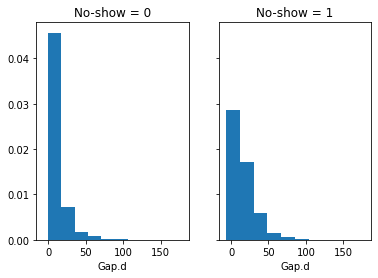

In [19]:
g = data.groupby('No-show')
fig, axes = plt.subplots(1, len(g), sharex = True, sharey = True)
axes = axes.flatten()
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(f"No-show = {cat}")
    axes[i].hist(group["Gap.d"], density=True)
    axes[i].set_xlabel('Gap.d')


The histograms indicate that:
(1) Among the <code>No-show == False</code> shorter gaps tend to be very common.
(2) Among the <code>No-show == True</code> longer gaps are not uncommon.

Going by the $\chi^2$ test, we should retain the <code>Gap.d</code> variable.

## Does patient id help us guess if the appointment is not going to be kept?

In [47]:
n_uniq_pat = len(data['PatientId'].unique())
print(f'# unique patients = {n_uniq_pat}')

# unique patients = 60270


In [48]:
avg_appointments = data.shape[0]/n_uniq_pat
print(f'On an average, a patient has {round(avg_appointments, 3)} appointments')

On an average, a patient has 1.775 appointments


array([[<AxesSubplot:title={'center':'AppointmentID'}>]], dtype=object)

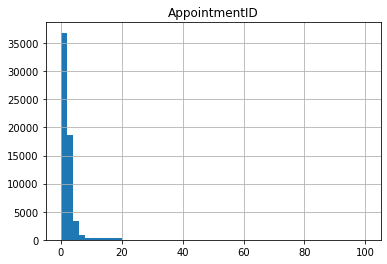

In [49]:
class_boundaries = [0, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
data[['PatientId', 'AppointmentID']].groupby('PatientId').count().hist(bins = class_boundaries)

In [50]:
run_chi_sq('PatientId', 'No-show', significance=0.05, print_results=False)

Reject the null hypothesis that the groups are same.


9.649216102948478e-49

$\chi^2$-test suggests that <code>PatientId</code> might be a significant variable.

## Conclusions
Variables that can determine the outcome are:
* <code>PatientId</code>
* <code>Age</code>
* <code>Neighbourhood</code>
* <code>Scholarship</code>
* <code>Hipertension</code>
* <code>Diabetes</code>
* <code>SMS_received</code>
* <code>Gap.d</code>

Among these variables, <code>Neighbourhood, Scholarship, Hipertension, Diabetes, Age</code> are a function of <code>PatientId</code>. Therefore, one should not include both of these together. Yet, <code>PatientId</code> is 
a synthetic identifier. It is not a 'natural' characteristic of a patient like <code>Neighbourhood, Scholarship, Hipertension, Diabetes</code> and <code>Age</code> are.